In [ ]:
!pip3 install gymnasium numpy gym

In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
from IPython.display import clear_output

In [4]:
rng_state = torch.load('rng_state.pth')
torch.set_rng_state(rng_state)
np.random.seed(100)
rng_state

/var/folders/zs/f8c7x0_j5tv_94s9q6dxq5nr0000gn/T/ipykernel_30600/2112421783.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rng_state = torch.load('rng_state.pth')


tensor([243,  34,  19,  ...,   0,   0,   0], dtype=torch.uint8)

In [5]:
# Define the Q-Network using a simple feedforward neural network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)  # Increased neurons for better GPU utilization
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)         # Third hidden layer with 128 units
        self.fc4 = nn.Linear(128, action_size) # Output layer with size equal to action space

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
# Define the DQN agent
class DQNAgent:
    # def __init__(self, state_size, action_size, num_users, num_uavs):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)
        self.gamma = 0.95  # Discount rate (lower for more exploration)
        self.epsilon = 1.0  # Exploration rate (start with full exploration)
        self.epsilon_min = 0.1 # Higher minimum epsilon for continued exploration
        self.epsilon_decay = 0.995 # Slower decay for extended exploration
        self.epsilon_reset_interval = 50  # Reset epsilon every 50 episodes
        self.learning_rate = 0.0005
        self.batch_size = 128
        self.model = QNetwork(state_size, action_size * 5).to(device)
        self.target_model = QNetwork(state_size, action_size * 5).to(device)  # Target network
        self.update_target_model()  # Initialize target model with the same weights
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.episode_count = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())  # Copy weights from the main model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Exploration
            return np.array([random.randrange(5) for _ in range(self.action_size)])
        # Exploitation
        state = torch.FloatTensor(state.flatten()).unsqueeze(0)
        act_values = self.model(state).cpu().detach().numpy()
        actions = [np.argmax(act_values[0, i*5:(i+1)*5]) for i in range(self.action_size)]
        return np.array(actions)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        q_values = self.model(states)
        next_q_values = self.target_model(next_states)  # Use target model for next_q_values
        q_target = q_values.clone()

        for i in range(self.batch_size):
            for j in range(self.action_size):
                q_target[i, j] = rewards[i] + (self.gamma * torch.max(next_q_values[i]) * (1 - dones[i]))

        self.optimizer.zero_grad()
        loss = self.criterion(q_values, q_target)

        # Normalize the loss, for example, by dividing by the batch size
        # normalized_loss = loss / self.batch_size

        # normalized_loss.backward()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay logic
        self.epsilon_decay_strategy()

        # Decay epsilon after each replay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # return normalized_loss.item()
        return loss.item()

    def epsilon_decay_strategy(self):
        # Regular epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        # Epsilon reset mechanism
        if self.episode_count > 0 and self.episode_count % self.epsilon_reset_interval == 0:
            self.epsilon = max(self.epsilon, 0.1)  # Reset epsilon to a higher value, but not exceeding 0.5

        self.episode_count += 1

In [7]:
class UAVClusterEnv(gym.Env):
    def __init__(self, num_users=10, num_uavs=3, area_size=100, max_steps=200):
        super(UAVClusterEnv, self).__init__()
        self.num_users = num_users
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.max_steps = max_steps  # Maximum number of steps in an episode
        self.min_observed_reward = float('inf')
        self.max_observed_reward = float('-inf')
        
        # State space: positions of users and UAVs
        self.observation_space = spaces.Box(
            low=0,
            high=area_size,
            shape=(self.num_users * 4 + self.num_uavs * 2,),  # 4 values (x, y, vx, vy) for each user, and 2 values (x, y) for each UAV
            dtype=np.float32
        )

        # Action space: UAVs can move in 4 directions (up, down, left, right)
        self.action_space = spaces.MultiDiscrete([5] * self.num_uavs)
        
        # Initialize environment state
        self.reset()

    def reset(self):
        self.users = np.random.rand(self.num_users, 2) * self.area_size
        
        # Use K-means to find clusters among the users
        kmeans = KMeans(n_clusters=self.num_uavs, n_init=10)
        kmeans.fit(self.users)
        self.uavs = kmeans.cluster_centers_  # Initialize UAVs at the centroids of the clusters
        
        self.user_velocities = np.random.uniform(-0.4, 0.4, (self.num_users, 2))
        self.current_step = 0
        return self._get_state()

    def step(self, action):
        self.current_step += 1
        
        # Update UAV positions based on the selected actions
        for i in range(self.num_uavs):
            direction = action[i]  # Direction for each UAV (0: up, 1: down, 2: left, 3: right)
            step_size = 0.4
            
            if direction == 0:  # Up
                self.uavs[i][1] += step_size
            elif direction == 1: # Down
                self.uavs[i][1] -= step_size
            elif direction == 2: # Left
                self.uavs[i][0] -= step_size
            elif direction == 3:  # Right
                self.uavs[i][0] += step_size
            elif direction == 4: # Stop
                continue
            
            # Boundary check to prevent UAVs from moving outside the map
            self.uavs[i][0] = np.clip(self.uavs[i][0], 0, self.area_size)  # Ensure x is within bounds
            self.uavs[i][1] = np.clip(self.uavs[i][1], 0, self.area_size)  # Ensure y is within bounds
            
        # Update user positions
        for i in range(self.num_users):
            self.users[i] += self.user_velocities[i]
            
            # Boundary check to prevent users from moving outside the map
            if self.users[i][0] < 0:
                self.users[i][0] = 0
                self.user_velocities[i][0] *= -1  # Reverse direction
                self.user_velocities[i][1] = np.random.uniform(-1, 1)  # Randomize the y direction
            elif self.users[i][0] > self.area_size:
                self.users[i][0] = self.area_size
                self.user_velocities[i][0] *= -1  # Reverse direction
                self.user_velocities[i][1] = np.random.uniform(-1, 1)  # Randomize the y direction
                
            if self.users[i][1] < 0:
                self.users[i][1] = 0
                self.user_velocities[i][1] *= -1  # Reverse direction
                self.user_velocities[i][0] = np.random.uniform(-1, 1)  # Randomize the x direction
            elif self.users[i][1] > self.area_size:
                self.users[i][1] = self.area_size
                self.user_velocities[i][1] *= -1  # Reverse direction
                self.user_velocities[i][0] = np.random.uniform(-1, 1)  # Randomize the x direction
            
            # Ensure the velocity isn't too small to cause the user to stop moving
            if np.linalg.norm(self.user_velocities[i]) < 0.1:
                self.user_velocities[i] += np.random.uniform(-0.2, 0.2, 2)  # Add a small random vector
        
        # Calculate the reward
        reward = self._calculate_reward()

        # print(f'normalized reward: {reward}')
        
        # Check if the episode is done
        done = self._is_done()

        return self._get_state(), reward, done, {}

    def _is_done(self):
        # Terminal condition: episode ends after a certain number of steps
        return self.current_step >= self.max_steps

    def _get_state(self):
        # Concatenate users' positions, velocities, and UAVs' positions
        users_state = np.concatenate([self.users, self.user_velocities], axis=1).flatten()
        uavs_state = self.uavs.flatten()
        return np.concatenate([users_state, uavs_state])
    
    def _calculate_reward(self):
        total_reward = 0
        board_center = np.array([self.area_size / 2, self.area_size / 2])

        # Apply K-Means to determine the clusters of users
        kmeans = KMeans(n_clusters=self.num_uavs, random_state=0).fit(self.users)
        cluster_centers = kmeans.cluster_centers_

        # Create a list to store which cluster each UAV is assigned to
        assigned_clusters = [-1] * self.num_uavs

        # Assign each UAV to the closest cluster center, with a condition on the distance
        for i, uav in enumerate(self.uavs):
            distances_to_clusters = np.linalg.norm(cluster_centers - uav, axis=1)
            closest_cluster_idx = np.argmin(distances_to_clusters)
            
            # If the closest cluster is farther than 5 units, venture to the center of the board
            if distances_to_clusters[closest_cluster_idx] > 5:
                distance_to_board_center = np.linalg.norm(uav - board_center)
                center_reward = 50 / (distance_to_board_center + 1)  # Reward for moving toward the center
                total_reward += center_reward
            else:
                # Assign the UAV to the closest cluster if within the threshold
                if assigned_clusters[closest_cluster_idx] == -1:
                    assigned_clusters[closest_cluster_idx] = i
                else:
                    # If the closest cluster is already assigned, check if this UAV is closer than the current one
                    current_uav_idx = assigned_clusters[closest_cluster_idx]
                    if distances_to_clusters[closest_cluster_idx] < np.linalg.norm(self.uavs[current_uav_idx] - cluster_centers[closest_cluster_idx]):
                        assigned_clusters[closest_cluster_idx] = i

        # Calculate rewards based on the assigned clusters
        for cluster_idx, uav_idx in enumerate(assigned_clusters):
            if uav_idx != -1:
                uav = self.uavs[uav_idx]
                distance_to_cluster_center = np.linalg.norm(uav - cluster_centers[cluster_idx])
                cluster_reward = 100 / (distance_to_cluster_center + 1)  # High reward for being near the center
                total_reward += cluster_reward

        # Boundary Penalty to discourage UAVs from staying near the edges
        # boundary_penalty = 0
        # for uav in self.uavs:
        #     min_dist_to_boundary = min(uav[0], self.area_size - uav[0], uav[1], self.area_size - uav[1])
        #     boundary_penalty += np.exp(-min_dist_to_boundary) * 20
        # total_reward -= boundary_penalty

        # Normalize the reward
        self.min_observed_reward = min(self.min_observed_reward, total_reward)
        self.max_observed_reward = max(self.max_observed_reward, total_reward)

        if self.min_observed_reward == self.max_observed_reward:
            normalized_reward = 0.5
        else:
            normalized_reward = (total_reward - self.min_observed_reward) / (self.max_observed_reward - self.min_observed_reward)

        return normalized_reward

    def render(self, mode='human'):
        # Optional: Visualize the environment using a plotting library
        pass

In [8]:
def train_dqn_agent(env, agent, n_episodes=500, max_steps_per_episode=100, stop_loss_threshold=0.00001, patience=10):
    losses = []
    rewards = []
    avg_user_distances = []
    coverage_overlaps = []
    coverage_uniformities = []
    normalized_rewards = []
    stop_loss_counter = 0

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        episode_losses = []
        start_time = time.time()

        for step in range(max_steps_per_episode):
            action = agent.act(state)
            # print(f'action: {action}')
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            loss = agent.replay()
            if loss is not None:
                episode_losses.append(loss)

            if done:
                break

        avg_loss = np.mean(episode_losses) if episode_losses else 0
        epsilon = agent.epsilon

        # Calculate metrics after each episode
        avg_distance = np.mean([np.min(np.linalg.norm(env.users - uav, axis=1)) for uav in env.uavs])
        coverage_overlap = sum(
            [max(0, env.area_size / 3 - np.linalg.norm(env.uavs[i] - env.uavs[j]))
             for i in range(len(env.uavs)) for j in range(i + 1, len(env.uavs))]
        )
        user_counts = np.zeros(len(env.uavs))
        for user in env.users:
            nearest_uav_idx = np.argmin(np.linalg.norm(env.uavs - user, axis=1))
            user_counts[nearest_uav_idx] += 1
        coverage_uniformity = np.var(user_counts)
        normalized_reward = total_reward / (len(env.users) * len(env.uavs))

        # Store the metrics
        avg_user_distances.append(avg_distance)
        coverage_overlaps.append(coverage_overlap)
        coverage_uniformities.append(coverage_uniformity)
        normalized_rewards.append(normalized_reward)

        rewards.append(total_reward)
        losses.append(avg_loss)

        end_time = time.time()
        episode_duration = end_time - start_time
        avg_reward = np.mean(rewards[-100:])

        print(
            f"Episode {episode + 1}/{n_episodes} | "
            f"Epsilon: {epsilon:.2f} | "
            f"Avg Reward: {avg_reward:.2f} | "
            f"Avg Loss: {avg_loss:.4f} | "
            f"Time: {episode_duration:.2f}s | "
            f"Avg Distance: {avg_distance:.2f} | "
            f"Overlap: {coverage_overlap:.2f} | "
            f"Uniformity: {coverage_uniformity:.2f} | "
            f"Normalized Reward: {normalized_reward:.4f}"
        )

        # Check for stop loss condition
        if avg_loss < stop_loss_threshold:
            stop_loss_counter += 1
            if stop_loss_counter >= patience:
                print(f"Training stopped early at episode {episode + 1} due to consistently low loss.")
                break
        else:
            stop_loss_counter = 0  # Reset counter if loss increases
        
        # Update the target model periodically
        if episode % 10 == 0:
            agent.update_target_model()

    # Save the model weights after training
    torch.save(agent.model.state_dict(), f'dqn_weights_users{env.num_users}_uavs{env.num_uavs}_area{env.area_size}.pth')
    print(f"Model weights saved.")

    # Plotting the losses and rewards
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(losses, label="Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Loss per Episode")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(rewards, label="Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode")
    plt.legend()

    plt.show()

    return rewards, losses, avg_user_distances, coverage_overlaps, coverage_uniformities, normalized_rewards


In [9]:
# Create the environment and DQN agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_users = 10
num_uavs = 3
env = UAVClusterEnv(num_users=num_users, num_uavs=num_uavs, area_size=10)
state_size = np.prod(env.observation_space.shape)
action_size = env.action_space.shape[0]

# IF using non-existing model, use this code:
agent = DQNAgent(state_size, action_size)

# IF using existing model, uncomment this code:
agent.model.to(device)

# Initialize the model (make sure it matches the structure of the saved model)
# agent = DQNAgent(state_size, action_size)

# # Load the saved weights
# agent.model.load_state_dict(torch.load("dqn_weights_users10_uavs3_area30.pth"))

/var/folders/zs/f8c7x0_j5tv_94s9q6dxq5nr0000gn/T/ipykernel_30600/3449607638.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.model.load_state_dict(torch.load("dqn_

<All keys matched successfully>

Episode 1/150 | Epsilon: 1.00 | Avg Reward: 9.84 | Avg Loss: 0.0000 | Time: 0.07s | Avg Distance: 6.55 | Overlap: 0.00 | Uniformity: 1.56 | Normalized Reward: 0.3281
Episode 2/150 | Epsilon: 0.48 | Avg Reward: 16.08 | Avg Loss: 0.0093 | Time: 1.50s | Avg Distance: 4.21 | Overlap: 2.95 | Uniformity: 0.22 | Normalized Reward: 0.7440
Episode 3/150 | Epsilon: 0.18 | Avg Reward: 14.02 | Avg Loss: 0.0018 | Time: 1.98s | Avg Distance: 2.65 | Overlap: 0.00 | Uniformity: 1.56 | Normalized Reward: 0.3296
Episode 4/150 | Epsilon: 0.10 | Avg Reward: 12.05 | Avg Loss: 0.0016 | Time: 2.03s | Avg Distance: 6.95 | Overlap: 0.00 | Uniformity: 6.22 | Normalized Reward: 0.2051
Episode 5/150 | Epsilon: 0.10 | Avg Reward: 12.70 | Avg Loss: 0.0012 | Time: 1.91s | Avg Distance: 9.98 | Overlap: 6.59 | Uniformity: 8.22 | Normalized Reward: 0.5094
Episode 6/150 | Epsilon: 0.10 | Avg Reward: 11.82 | Avg Loss: 0.0010 | Time: 1.82s | Avg Distance: 4.64 | Overlap: 1.00 | Uniformity: 1.56 | Normalized Reward: 0.2475

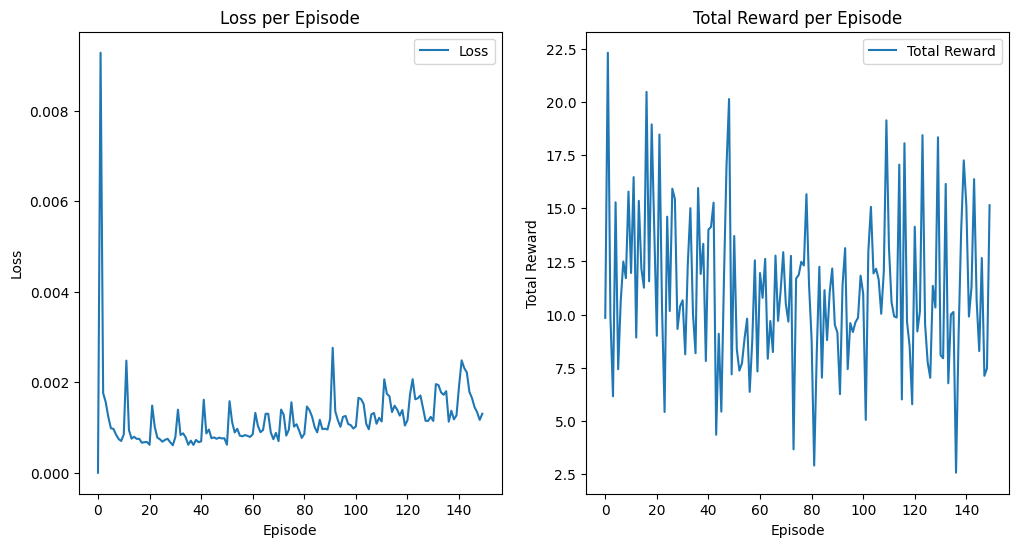

In [41]:
# Train the DQN agent
(
    train_rewards,
    train_losses,
    avg_user_distances,
    coverage_overlaps,
    coverage_uniformities, 
    normalized_rewards
) = train_dqn_agent(env, agent, n_episodes=150)
# rewards, losses = train_dqn_agent(env, agent, n_episodes=500, max_steps_per_episode=100, stop_loss_threshold=0.001)

In [10]:
def test_dqn_agent(env, agent, n_episodes=5, max_steps_per_episode=100):
    """
    Test the DQN agent in the environment for a given number of episodes with visualization.
    
    Args:
        env: The environment to test in.
        agent: The DQN agent.|
        n_episodes: Number of episodes to run.
        max_steps_per_episode: Maximum number of steps per episode.
    
    Returns:
        total_rewards: List of total rewards obtained in each episode.
        metrics: Dictionary containing various evaluation metrics.
    """
    total_rewards = []
    avg_user_distances = []
    coverage_overlaps = []
    coverage_uniformities = []
    normalized_rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Clear the previous plot
            clear_output(wait=True)

            # Plot the environment
            plt.figure(figsize=(8, 8))
            plt.xlim(0, env.area_size)
            plt.ylim(0, env.area_size)
            plt.scatter(env.users[:, 0], env.users[:, 1], color='blue', label='Users')
            plt.scatter(env.uavs[:, 0], env.uavs[:, 1], color='red', label='UAVs')

            # Apply K-Means to determine the clusters of users
            kmeans = KMeans(n_clusters=len(env.uavs), random_state=0).fit(env.users)
            cluster_centers = kmeans.cluster_centers_

            # Center of the board
            board_center = np.array([env.area_size / 2, env.area_size / 2])

            # Annotate and display rewards for each UAV
            for i, uav in enumerate(env.uavs):
                cluster_reward = 0
                boundary_penalty = 0
                center_reward = 0

                # Calculate distance to the closest cluster center
                distance_to_cluster_center = np.linalg.norm(uav - cluster_centers[i])

                if distance_to_cluster_center > 5:
                    # If the cluster is too far, encourage the UAV to move to the center of the board
                    distance_to_board_center = np.linalg.norm(uav - board_center)
                    center_reward = 50 / (distance_to_board_center + 1)  # Reward for moving toward the center
                    plt.plot([uav[0], board_center[0]], [uav[1], board_center[1]], 'g--', lw=1)
                else:
                    # Otherwise, reward the UAV for staying close to the cluster center
                    cluster_reward = 100 / (distance_to_cluster_center + 1)  # High reward for being near the center
                    plt.plot([uav[0], cluster_centers[i][0]], [uav[1], cluster_centers[i][1]], 'k--', lw=1)

                # Boundary Penalty
                min_dist_to_boundary = min(uav[0], env.area_size - uav[0], uav[1], env.area_size - uav[1])
                boundary_penalty = np.exp(-min_dist_to_boundary) * 20

                # Calculate total UAV reward
                total_uav_reward = cluster_reward + center_reward - boundary_penalty
                plt.text(uav[0], uav[1], f'Reward: {total_uav_reward:.2f}', fontsize=10, color='black', ha='center')

            plt.title(f'Episode {episode + 1}, Step {step + 1}')
            plt.legend()
            plt.show()

            state = next_state

            if done:
                break

        # Calculate metrics after the episode
        avg_distance = np.mean([np.min(np.linalg.norm(env.users - uav, axis=1)) for uav in env.uavs])
        coverage_overlap = sum(
            [max(0, env.area_size / 3 - np.linalg.norm(env.uavs[i] - env.uavs[j]))
             for i in range(len(env.uavs)) for j in range(i + 1, len(env.uavs))]
        )
        user_counts = np.zeros(len(env.uavs))
        for user in env.users:
            nearest_uav_idx = np.argmin(np.linalg.norm(env.uavs - user, axis=1))
            user_counts[nearest_uav_idx] += 1
        coverage_uniformity = np.var(user_counts)
        normalized_reward = total_reward / (len(env.users) * len(env.uavs))

        # Store the metrics
        avg_user_distances.append(avg_distance)
        coverage_overlaps.append(coverage_overlap)
        coverage_uniformities.append(coverage_uniformity)
        normalized_rewards.append(normalized_reward)

        total_rewards.append(total_reward)
        print(f"Test Episode {episode + 1}/{n_episodes} | Total Reward: {total_reward:.2f} | Avg Distance: {avg_distance:.2f} | "
              f"Overlap: {coverage_overlap:.2f} | Uniformity: {coverage_uniformity:.2f} | Normalized Reward: {normalized_reward:.4f}")

    avg_reward = np.mean(total_rewards)
    avg_distance = np.mean(avg_user_distances)
    avg_overlap = np.mean(coverage_overlaps)
    avg_uniformity = np.mean(coverage_uniformities)
    avg_normalized_reward = np.mean(normalized_rewards)

    print(f"\nAverage Reward over {n_episodes} Test Episodes: {avg_reward:.2f}")
    print(f"Average User Distance: {avg_distance:.2f}")
    print(f"Average Coverage Overlap: {avg_overlap:.2f}")
    print(f"Average Coverage Uniformity: {avg_uniformity:.2f}")
    print(f"Average Normalized Reward: {avg_normalized_reward:.4f}")

    metrics = {
        "avg_reward": avg_reward,
        "avg_distance": avg_distance,
        "avg_overlap": avg_overlap,
        "avg_uniformity": avg_uniformity,
        "avg_normalized_reward": avg_normalized_reward
    }
    
    return total_rewards, metrics

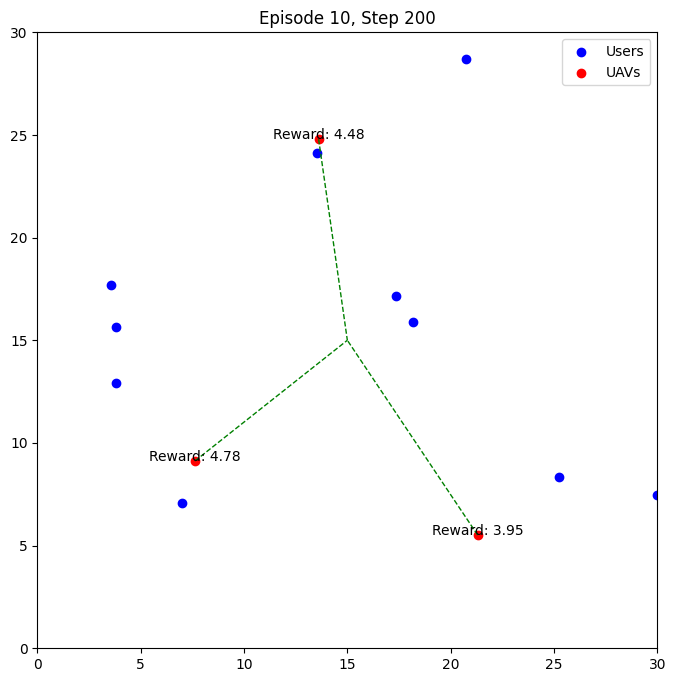

Test Episode 10/10 | Total Reward: 25.86 | Avg Distance: 2.55 | Overlap: 0.00 | Uniformity: 0.89 | Normalized Reward: 0.8620

Average Reward over 10 Test Episodes: 23.64
Average User Distance: 4.89
Average Coverage Overlap: 0.61
Average Coverage Uniformity: 3.76
Average Normalized Reward: 0.7880


In [11]:
test_rewards = test_dqn_agent(env, agent, n_episodes=10, max_steps_per_episode=200)